In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import os
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
import datetime
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, recall_score, precision_score

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler

from torch import nn, randn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
import warnings

import time
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_chunked

/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be r

# Pré processamento

In [2]:
df = pd.read_csv("./weather.csv")
date = df['Date']    
df = df.drop(['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM', 'RainToday'],axis=1) #remove id column
df = df.dropna()

sin = []
cos = []
for i, date in enumerate(df['Date']):
    d = date
    year, month, day = map(int, d.split('-'))
    d = datetime.date(year, month, day)
    day_number = d.timetuple().tm_yday
    sin.append(np.sin(math.pi*2*(day_number - 1)/364)) 
    cos.append(np.cos(math.pi*2*(day_number - 1)/364)) 
df['Date_cos'] = cos
df['Date_sin'] = sin    

wind_directions = {
    'N': 90.0, 
    'NNE': (90 + 45) / 2,
    'NE': 45.0,
    'ENE': (45) / 2,
    'E': 0.0,
    'ESE': (0 - 45) / 2,
    'SE': -45.0,
    'SSE': (-90 - 45) / 2,
    'S': -90.0,
    'SSW': (-90 - 135) / 2,
    'SW': -135.0,
    'WSW': (180 - 135) / 2,
    'W': 180.0,
    'WNW': (180 + 135) / 2,
    'NW': 135.0,
    'NNW': (135 + 90) / 2
}

df['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace = True)

def log(x):
        return np.log(x+0.1)

df['Rainfall'] = df['Rainfall'].apply(log) 

for column in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[column].replace(wind_directions, inplace = True)
    df[column + '_cos'] = df[column].apply(np.cos) 
    df[column + '_sin'] = df[column].apply(np.sin)
    df.drop([column], axis=1, inplace=True)
   

df_autocorr = df.copy()

df = df.drop(['Date'],axis=1) #remove unused date column
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,Temp3pm,RainTomorrow,Date_cos,Date_sin,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
0,13.4,22.9,-0.356675,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,...,21.8,0,0.877303,-0.479937,-0.598460,-0.801153,-0.598460,-0.801153,0.912939,0.408096
1,7.4,25.1,-2.302585,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,...,24.3,0,0.885456,-0.464723,0.912939,0.408096,0.826837,-0.562441,-0.873305,-0.487175
2,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,23.2,0,0.893346,-0.449370,-0.873305,-0.487175,-0.598460,-0.801153,-0.873305,-0.487175
3,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,26.5,0,0.900969,-0.433884,0.525322,0.850904,0.525322,-0.850904,1.000000,0.000000
4,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,29.7,0,0.908324,-0.418268,-0.598460,-0.801153,-0.873305,-0.487175,-0.996088,0.088369


In [13]:
df.describe().transpose().drop(['25%', '50%', '75%'], axis=1)

,count,mean,std,min,max
MinTemp,112925.0,12.664721,6.254135,-8.200000,33.900000
MaxTemp,112925.0,23.655670,6.982702,2.600000,48.100000
Rainfall,112925.0,-1.184042,1.746133,-2.302585,5.907267
WindGustSpeed,112925.0,40.786611,13.321774,7.000000,135.000000
WindSpeed9am,112925.0,15.179163,8.344304,2.000000,87.000000
WindSpeed3pm,112925.0,19.500545,8.580097,2.000000,87.000000
Humidity9am,112925.0,67.404162,18.911610,0.000000,100.000000
Humidity3pm,112925.0,50.669055,20.768550,0.000000,100.000000
Pressure9am,112925.0,1017.425847,7.032654,980.500000,1041.000000
Pressure3pm,112925.0,1015.048962,6.957822,977.100000,1039.600000


## Gráficos de autocorrelação

Os dois registros anteriores das vairáveis que apresentarem maior autocorrelação serão usados como variáveis de entrada do modelo

In [4]:
df_autocorr.index = pd.Index(df_autocorr['Date'].values.squeeze())
#df_autocorr = df_autocorr.drop(['Date'], axis=1)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

for column in df_autocorr:
    sm.graphics.tsa.plot_acf(df_autocorr.drop(df_autocorr.columns.difference([column]), 1)[:1000].values.squeeze(), lags=60)
    plt.title(column)
    plt.show()

In [5]:
for col in df:
    if col in ["Humidity3pm","Humidity9am","MinTemp","MaxTemp"]:
        df[col+'-1'] = df[col].shift(periods=1, axis=0)
        df[col+'-2'] = df[col].shift(periods=2, axis=0)

df = df.iloc[2:]
df = df.reset_index(drop=True)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_cos,WindDir3pm_sin,MinTemp-1,MinTemp-2,MaxTemp-1,MaxTemp-2,Humidity9am-1,Humidity9am-2,Humidity3pm-1,Humidity3pm-2
0,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,-0.873305,-0.487175,7.4,13.4,25.1,22.9,44.0,71.0,25.0,22.0
1,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,1.000000,0.000000,12.9,7.4,25.7,25.1,38.0,44.0,30.0,25.0
2,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,-0.996088,0.088369,9.2,12.9,28.0,25.7,45.0,38.0,16.0,30.0
3,14.6,29.7,-1.203973,56.0,19.0,24.0,55.0,23.0,1009.2,1005.4,...,-0.598460,-0.801153,17.5,9.2,32.3,28.0,82.0,45.0,33.0,16.0
4,14.3,25.0,-2.302585,50.0,20.0,24.0,49.0,19.0,1009.6,1008.2,...,-0.598460,-0.801153,14.6,17.5,29.7,32.3,55.0,82.0,23.0,33.0


In [6]:
df_norm = df.drop(['RainTomorrow'], axis=1)
df_norm = (df_norm - df_norm.mean())/df_norm.std()
df_norm.describe().transpose().drop(['25%', '50%', '75%', 'count'], axis=1)

,mean,std,min,max
MinTemp,2.238238e-14,1.0,-3.336136,3.395373
MaxTemp,3.624351e-14,1.0,-3.015377,3.500668
Rainfall,7.372212e-13,1.0,-0.640580,4.061125
WindGustSpeed,2.021079e-16,1.0,-2.536169,7.072081
WindSpeed9am,-9.664937e-17,1.0,-1.579428,8.607168
WindSpeed3pm,-1.932987e-16,1.0,-2.039645,7.866930
Humidity9am,-2.255152e-16,1.0,-3.564171,1.723576
Humidity3pm,-1.167847e-16,1.0,-2.439740,2.375263
Pressure9am,-2.037385e-12,1.0,-5.250668,3.352091
Pressure3pm,-1.494682e-12,1.0,-5.454173,3.528539


## Remoção de outliers

In [12]:
#Get mean distances

X = df_norm
mean = []
chunks = pairwise_distances_chunked(X)
for chunk in tqdm(chunks):
    mean.extend(chunk.mean(1))

96it [03:00,  1.88s/it]


### Gráfico de distâncias ordenadas

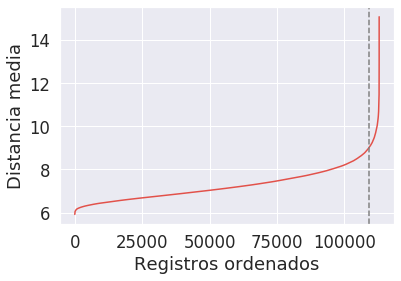

In [13]:
from ipywidgets import interact
import ipywidgets as widgets

sorted_mean = mean.copy()
sorted_mean.sort()

plt.plot(sorted_mean)
plt.xlabel('Registros ordenados')
plt.ylabel('Distancia media')
plt.axvline(x=109000, color="grey", linestyle="--")
plt.show()
    
    
# interact(plot, x=widgets.IntSlider(min=0, max=len(sorted_mean), step=1000, value=110000))

In [14]:
#Create dataframe without the outliers

df_distances = pd.DataFrame(mean, columns=["mean"])
df_distances = df_distances.sort_values(by=["mean"])
df_distances = df_distances.iloc[109000:]
df_distances.tail()

,mean
71508,12.575670
29978,12.587830
70242,12.921475
31154,13.054737
14762,15.086399


In [15]:
df_norm = df_norm.drop(df_distances.index.values.tolist())

In [19]:
df = df.drop(df_distances.index.values.tolist())

In [33]:
df_norm = (df_norm -df_norm.mean())/df_norm.std()

In [34]:
df_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,109000.0,-1.097234e-15,1.0,-3.389314,-0.738259,-0.034584,0.734549,2.812845
MaxTemp,109000.0,-1.585358e-16,1.0,-2.602256,-0.772581,-0.061881,0.739547,3.340408
Rainfall,109000.0,9.216456e-15,1.0,-0.643023,-0.643023,-0.643023,0.625009,3.913912
WindGustSpeed,109000.0,-1.033977e-14,1.0,-2.637139,-0.731433,-0.096198,0.618442,5.779728
WindSpeed9am,109000.0,9.586460e-15,1.0,-1.611770,-0.737547,-0.237990,0.636233,5.257128
WindSpeed3pm,109000.0,-2.436392e-14,1.0,-2.090238,-0.761350,-0.036502,0.567538,5.279050
Humidity9am,109000.0,-1.464370e-15,1.0,-3.756719,-0.624044,0.047243,0.718531,1.781403
Humidity3pm,109000.0,1.637508e-15,1.0,-2.545828,-0.706420,0.039286,0.685564,2.425544
Pressure9am,109000.0,-6.935940e-16,1.0,-4.239704,-0.672643,-0.012076,0.677850,3.422873
Pressure3pm,109000.0,-2.248705e-15,1.0,-4.591485,-0.685368,-0.002169,0.681031,3.502940


## Análise de Componentes Principais
Removemos o número de componentes principais que nos permita manter 98% da variância total dos dados

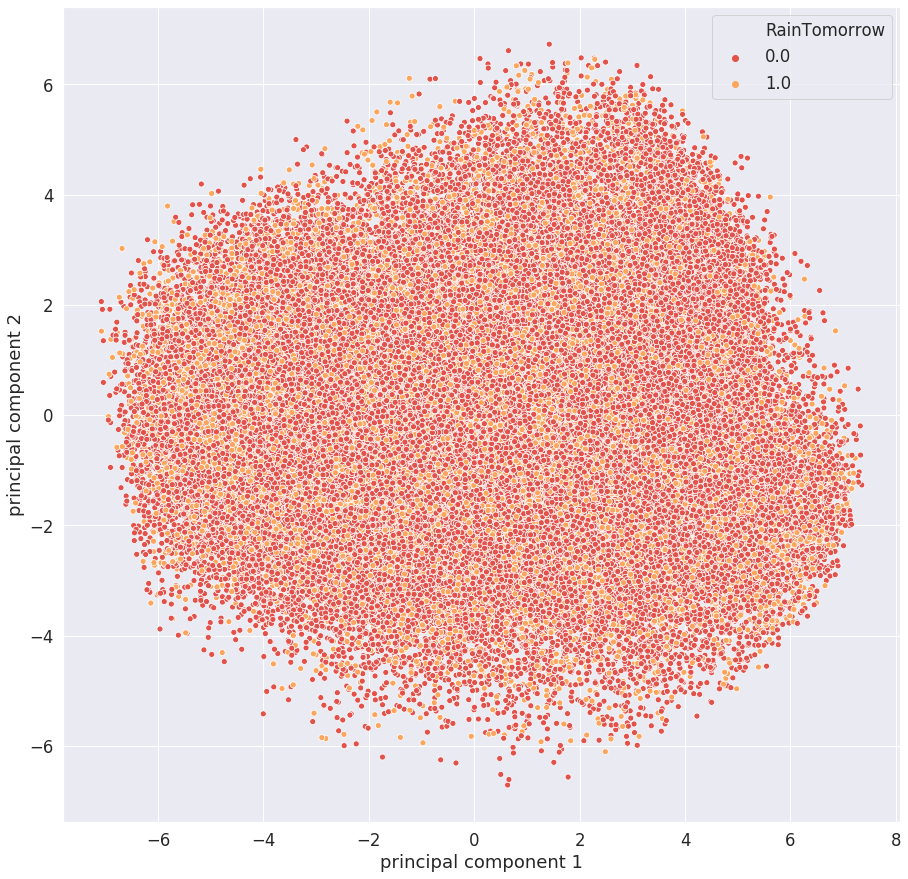

In [35]:
X = df_norm

pca = PCA(n_components=2)
pca.fit(X)
principalComponents = pca.transform(X)
principalData = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

target = df['RainTomorrow'] 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=principalData, x='principal component 1', y='principal component 2',hue=target, ax=ax, legend='full')

<BarContainer object of 21 artists>

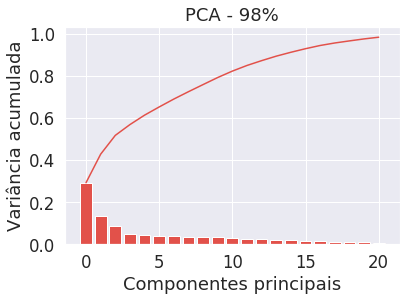

In [36]:
X = df_norm

pca = PCA(n_components=0.98)
pca.fit(X)
X_pca = pca.transform(X)

#plot explained_variance
plt.title("PCA - 98%")
plt.ylabel('Variância acumulada')
plt.xlabel('Componentes principais')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
y_pos = np.arange(len(pca.explained_variance_ratio_))
plt.bar(y_pos, pca.explained_variance_ratio_)

## Undersampling

In [48]:
X = df_norm
# X = X_pca
y = df['RainTomorrow']

# Split training data to enable model verification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

#Balancing train classes with undersampling
rus = RandomUnderSampler(random_state=0)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)


print("Shape")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print ("X_us:", X_train_undersampled.shape)
print ("y_us:", y_train_undersampled.shape)
print ("X_test:", X_test.shape)
print ("y_test:", y_test.shape)

Shape
X_train: (87200, 28)
y_train: (87200,)
X_us: (38310, 28)
y_us: (38310,)
X_test: (21800, 28)
y_test: (21800,)


/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Redução do dataset de treino para o gridsearch

In [49]:
X_train_resampled, y_train_resampled = resample(X_train_undersampled, y_train_undersampled, n_samples=10000, random_state=0)
X_train_resampled_unbalanced, y_train_resampled_unbalanced = resample(X_train, y_train, n_samples=10000, random_state=0)

# Modelos Lineares 

In [44]:
Cs = [0.001, 0.1, 1.0, 10.0]

models = [
    {
        'model': LogisticRegression(),
        'name': 'LogisticRegression',
        'parameters': [{
            'penalty': ['l1','l2', 'elasticnet', 'none'],
            'C': Cs,
            'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }]
    },
    {
        'model': RandomForestClassifier(),
        'name': 'RandomForest',
        'parameters': [{
            'n_estimators': [10, 100, 200, 500, 1000, 2000, 3000],
            'max_depth': [None, 3, 5, 10, 20, 50],
            'max_features': ['auto', 'sqrt', 'log2']
        }]
    },
    {
        'model': DecisionTreeClassifier(),
        'name': 'DecisionTree',
        'parameters': [{
            'max_depth': [1, 10, 20],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
        }]
    },
    {
        'model': KNeighborsClassifier(),
        'name': 'KNeighbors',
        'parameters': [{
            'n_neighbors': [1, 10, 20, 30],
            'p': [1,2,3, 4, 5],
        }]
    }
]



In [ ]:
for model in models:
    clf = GridSearchCV(model['model'], model['parameters'], cv=10, verbose=1, return_train_score=True, n_jobs=-1, scoring=['f1', 'roc_auc', 'accuracy', 'recall'], refit=False)
    clf.fit(X_train_resampled, y_train_resampled)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')
    results.to_csv('results_without_outliers/results_{0}_cv10_nopca.csv'.format(model['name']), index=False)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    5.9s finished


Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.5s
/home/iuro/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 30.7min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    4.6s finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.9s


In [ ]:
warnings.filterwarnings('ignore')

models = [
#     LinearRegression(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = [
#     'Linear Classifier',
    'Gaussian Naive Bayes',
    'Quadratic Discriminant Analysis',
]

for model, name in zip(models, names):
    scores = cross_validate(model, X_resampled, y_resampled, cv=10, scoring=['precision_macro','recall_macro','accuracy','f1_macro'])
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tF1-Score: {}\n\tAccuracy: {}\n".format(name,np.mean(scores['test_precision_macro']),np.mean(scores['test_recall_macro']),np.mean(scores['test_f1_macro']), np.mean(scores['test_accuracy'])))
  
    y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=5)
    confusion = confusion_matrix(y_resampled, y_pred)
    
    p = sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()

# Modelos não lineares

## SVM

In [27]:
gammas = ['auto', 'scale', 0.0001 ,0.001 ,0.01 ,1.0, 10.0, 100.0, 1000.0]
Cs = [0.0001 ,0.001 ,0.01 ,1.0, 10.0, 100.0, 1000.0]
# Cs = [0.0001]
# gammas = ['auto',0.01]

parameters = [
    {
        'kernel': ['rbf'],
        'gamma': gammas,
        'C': Cs
    },
#     {
#         'kernel': ['linear'],
#         'C': Cs
#     },
    {
        'kernel': ['sigmoid'],
        'gamma': [1, 0.5, 0.01],
        'C': Cs
    },
    {
        'kernel': ['poly'],
        'gamma': ['scale'],
        'degree': [2, 3, 4, 5],
        'C': Cs
    }
]

In [43]:
for param in parameters:
    print(param)
    clf = GridSearchCV(SVC(), param, cv=10, verbose=1, return_train_score=True, n_jobs=-1, scoring=['f1', 'roc_auc', 'accuracy', 'recall'], refit=False)
    clf.fit(X_train_resampled_unbalanced, y_train_resampled_unbalanced)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')
    results.to_csv('results_without_outliers/results_{0}_cv10_pca98_unbalanced.csv'.format(param['kernel'][0]), index=False)

{'kernel': ['rbf'], 'gamma': ['auto', 'scale', 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0], 'C': [0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
/home/iuro/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 11.2min finished


{'kernel': ['sigmoid'], 'gamma': [1, 0.5, 0.01], 'C': [0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.7min finished


{'kernel': ['poly'], 'gamma': ['scale'], 'degree': [2, 3, 4, 5], 'C': [0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.5s
/home/iuro/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 14.2min finished


In [26]:
clf = SVC(gamma='auto', C=1.0, kernel='rbf')
clf.fit(X_train_undersampled, y_train_undersampled)
clf.score(X_test, y_test)

0.801605504587156

In [78]:
clf.score(X_test, y_test)

0.8550808058445871

### Melhor modelo: $\gamma = scale$ , $C = 1000$, $kernel: RBF$  

### Rede Neural

In [88]:
class TorchModule(nn.Module):
    def __init__(self, num_units=10):
        super(TorchModule, self).__init__()

        self.activation = F.relu
                
        self.hidden = nn.Linear(28, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = self.activation(self.hidden(X))
        X = F.softmax(self.output(X), dim=1)
        return X

net = NeuralNetClassifier(
    TorchModule,
    max_epochs=2,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

X = df.drop(['RainTomorrow', 'RainToday'], axis=1).values.astype(np.float32)
y = df['RainTomorrow'].values.astype(np.int64)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       12.4103       0.2216       12.4102  0.9473
      2       12.4103       0.2216       12.4102  0.9681
      3       12.4103       0.2216       12.4102  0.9453
      4       12.4103       0.2216       12.4102  1.0656
      5       12.4103       0.2216       12.4102  1.0328
      6       12.4103       0.2216       12.4102  0.9817
      7       12.4103       0.2216       12.4102  0.9907
      8       12.4103       0.2216       12.4102  0.9315
      9       12.4103       0.2216       12.4102  0.9311
     10       12.4103       0.2216       12.4102  1.0073
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       12.4103       0.2216       12.4102  0.9822
      2       12.4103       0.2216       12.4102  0.9718
      3       12.4103       0.2216       12.4102  0.9766
      4       12.4103       0.2

In [89]:
class TorchModule2(nn.Module):
    def __init__(self, num_units=10):
        super(TorchModule2, self).__init__()

        self.activation = F.relu
                
        self.hidden0 = nn.Linear(28, num_units)
        self.dropout = nn.Dropout(0.5)
        self.hidden1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.activation(self.hidden0(X))
        X = self.dropout(X)
        X = self.activation(self.hidden1(X))
        X = F.softmax(self.output(X), dim=1)
        return X

net = NeuralNetClassifier(
    TorchModule2,
    max_epochs=2,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

X = df.drop(['RainTomorrow', 'RainToday'], axis=1).values.astype(np.float32)
y = df['RainTomorrow'].values.astype(np.int64)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0409       0.7784        3.5322  1.0442
      2        2.0232       0.7784        3.5322  1.0761
      3        2.0186       0.7784        3.5322  1.0124
      4        2.0357       0.7784        3.5322  1.0432
      5        2.0282       0.7784        3.5322  1.0338
      6        2.0214       0.7784        3.5322  1.0014
      7        2.0183       0.7784        3.5322  1.0119
      8        2.0446       0.7784        3.5322  1.0281
      9        2.0110       0.7784        3.5322  1.0199
     10        2.0542       0.7784        3.5322  1.0052
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.8064       0.7784        3.5322  1.1240
      2        2.8042       0.7784        3.5322  1.0732
      3        2.7957       0.7784        3.5322  1.1111
      4        2.7808       0.7

In [94]:
#y_proba = net.predict_proba(X)

print(X[0])
#print(y_proba)


[ 1.2900000e+01  2.5700001e+01 -2.3025851e+00  4.6000000e+01
  1.9000000e+01  2.6000000e+01  3.8000000e+01  3.0000000e+01
  1.0076000e+03  1.0087000e+03  2.1000000e+01  2.3200001e+01
  8.9334553e-01 -4.4937041e-01 -8.7330467e-01 -4.8717451e-01
 -5.9846008e-01 -8.0115265e-01 -8.7330467e-01 -4.8717451e-01
  7.4000001e+00  1.3400000e+01  2.5100000e+01  2.2900000e+01
  4.4000000e+01  7.1000000e+01  2.5000000e+01  2.2000000e+01]
